# 4. Model Monitoring

### Load model 

In [1]:
from joblib import load
from io import BytesIO
import requests

In [2]:
class CreditChurnClassification():
    
    def __init__(self, model, features, acc):
        self.model = model
        self.features = features
        self.acc = acc

In [3]:
model_path = 'https://github.com/apollo-robin/customer-churn/raw/main/Models/Churn_xgb_top.pkl?raw=true'
model_file = BytesIO(requests.get(model_path).content)
prediction_model = load(model_file)

In [4]:
preprocessor = prediction_model.model.steps[0][1]
preprocessor

ColumnTransformer(transformers=[('ohe', OneHotEncoder(), ['Gender']),
                                ('bin',
                                 KBinsDiscretizer(encode='ordinal',
                                                  strategy='uniform'),
                                 ['Total_Revolving_Bal', 'Total_Trans_Amt']),
                                ('scaler', StandardScaler(),
                                 ['Total_Trans_Ct', 'Total_Relationship_Count',
                                  'Customer_Age', 'Total_Ct_Chng_Q4_Q1',
                                  'Months_Inactive_12_mon',
                                  'Avg_Utilization_Ratio',
                                  'Total_Amt_Chng_Q4_Q1'])])

In [5]:
clf_model = prediction_model.model.steps[1][1]
clf_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0.5, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

### Load data

In [6]:
import pandas as pd
import sklearn
import warnings

In [7]:
churn_train = pd.read_pickle('https://github.com/apollo-robin/customer-churn/raw/main/DataFiles/processed/churn_train.pkl')
churn_test = pd.read_pickle('https://github.com/apollo-robin/customer-churn/raw/main/DataFiles/processed/churn_test.pkl')
churn_prod = pd.read_pickle('https://github.com/apollo-robin/customer-churn/raw/main/DataFiles/processed/churn_prod.pkl')

In [8]:
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [9]:
feature_name = get_feature_names(prediction_model.model.steps[0][1])

C:\Users\robin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\robin\anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Transformer bin (type KBinsDiscretizer) does not provide get_feature_names. Will return input column names if available
C:\Users\robin\anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available


## 4.1 Drift Monitoring

In [10]:
!pip install evidently --user

Traceback (most recent call last):
  File "c:\users\robin\anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\robin\anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\robin\anaconda3\Scripts\pip.exe\__main__.py", line 5, in <module>
ModuleNotFoundError: No module named 'pip'


In [11]:
from evidently.dashboard import Dashboard
from evidently.tabs import DataDriftTab, ClassificationPerformanceTab

### 4.1.2 Data Drift Report

In [12]:
reference = pd.DataFrame(prediction_model.model.steps[0][1].transform(churn_train),columns= feature_name)
production = pd.DataFrame(prediction_model.model.steps[0][1].transform(churn_prod),columns= feature_name)

In [13]:
data_drift_report = Dashboard(tabs=[DataDriftTab])
data_drift_report.calculate(reference,production, column_mapping = None)
data_drift_report.save("../Reports/Data Drift.html")

### 4.1.3 Classification Performance Report

In [14]:
reference['target'] = churn_train['Attrition_Flag']
reference['prediction'] = prediction_model.model.predict(churn_train)

In [15]:
production['target'] = churn_prod['Attrition_Flag'].to_numpy()
production['prediction'] = prediction_model.model.predict(churn_prod)

In [16]:
classification_performance_report = Dashboard(tabs=[ClassificationPerformanceTab])
classification_performance_report.calculate(reference, production, column_mapping = None)
classification_performance_report.save('../Reports/Classifiaction Performance.html')

## 4.2 Model Explanation

### Train and Test Datsets

In [17]:
X_train = pd.DataFrame(preprocessor.transform(churn_train),columns= feature_name)
X_test = pd.DataFrame(preprocessor.transform(churn_test),columns= feature_name)

y_train = churn_train['Attrition_Flag']
y_test = churn_test['Attrition_Flag']

In [18]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

### 4.2.1 Partial Dependence Plots (PDPs)

#### Effect of Transaction Count on Attrition

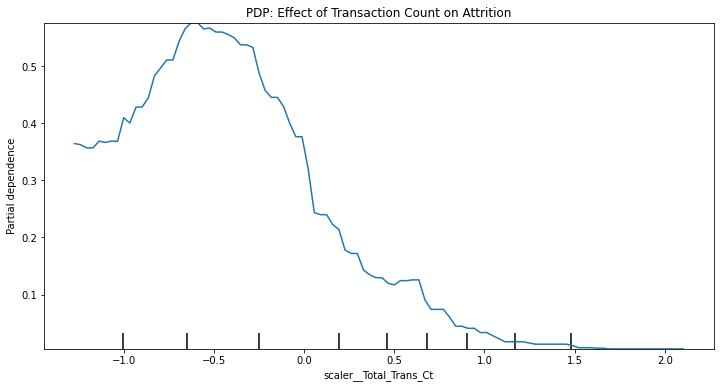

In [19]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("PDP: Effect of Transaction Count on Attrition")
PartialDependenceDisplay.from_estimator(clf_model,
                                        X_test,
                                        features = ['scaler__Total_Trans_Ct'],
                                        feature_names = feature_name,
                                        ax = ax);

#### Effect of Revolving Balance on Attrition

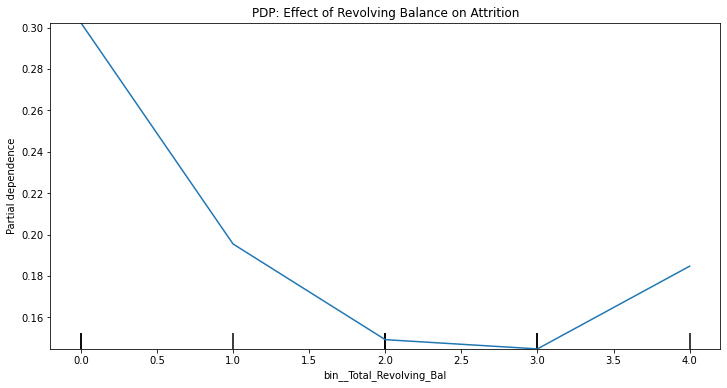

In [20]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("PDP: Effect of Revolving Balance on Attrition")
PartialDependenceDisplay.from_estimator(clf_model,
                                        X_test,
                                        features = ['bin__Total_Revolving_Bal'],
                                        feature_names = feature_name,
                                        ax = ax);

#### Effect of Relationship Count on Attrition

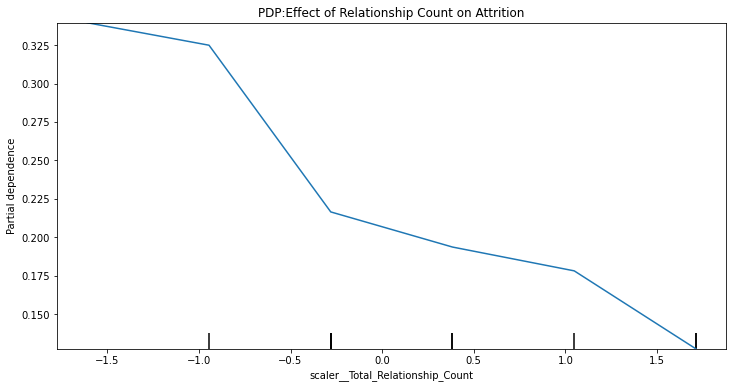

In [21]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("PDP:Effect of Relationship Count on Attrition")
PartialDependenceDisplay.from_estimator(clf_model,
                                        X_test,
                                        features = ['scaler__Total_Relationship_Count'],
                                        feature_names = feature_name,
                                        ax = ax);

#### Effect of Transaction Amount on Attrition

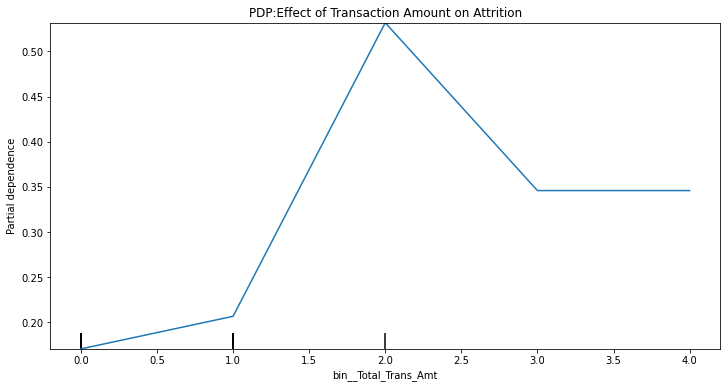

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("PDP:Effect of Transaction Amount on Attrition")
PartialDependenceDisplay.from_estimator(clf_model,
                                        X_test,
                                        features = ['bin__Total_Trans_Amt'],
                                        feature_names = feature_name,
                                        ax = ax);

#### Effect of Gender on Attrition

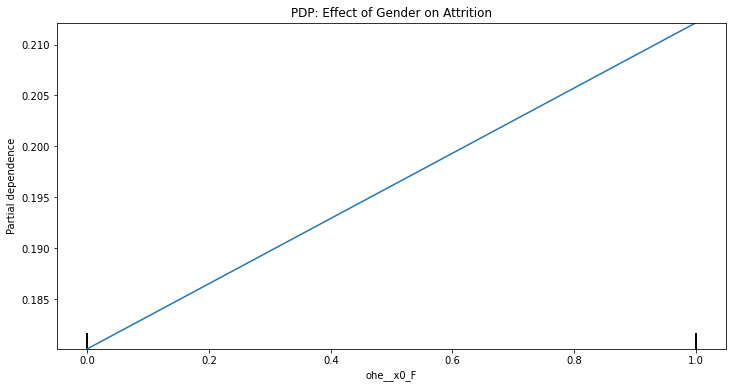

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("PDP: Effect of Gender on Attrition")
PartialDependenceDisplay.from_estimator(clf_model,
                                        X_test,
                                        features = ['ohe__x0_F'],
                                        feature_names = feature_name,
                                        ax = ax);

### 4.2.2 LIME

In [24]:
import lime
import lime.lime_tabular

In [25]:
explainer = (lime
             .lime_tabular
             .LimeTabularExplainer(training_data = X_train.to_numpy(), 
                                   training_labels = y_train,                                   
                                   feature_names = feature_name, 
                                   class_names = ['Existing', 'Attrition'],
                                   #categorical_features = ['famhist_Present'],
                                   #categorical_names = ['famhist_Present'], 
                                   kernel_width=3,
                                   verbose = True ))

#### Explaining a case of No Attrition

In [26]:
X_test.iloc[0]

ohe__x0_F                           1.000000
ohe__x0_M                           0.000000
bin__Total_Revolving_Bal            3.000000
bin__Total_Trans_Amt                0.000000
scaler__Total_Trans_Ct             -0.074074
scaler__Total_Relationship_Count   -0.280410
scaler__Customer_Age                1.054483
scaler__Total_Ct_Chng_Q4_Q1         0.084659
scaler__Months_Inactive_12_mon      0.695313
scaler__Avg_Utilization_Ratio       0.941627
scaler__Total_Amt_Chng_Q4_Q1       -0.780702
Name: 0, dtype: float64

In [27]:
exp = explainer.explain_instance( X_test.iloc[0].to_numpy(), 
                                  clf_model.predict_proba )

Intercept 0.5154889113153562
Prediction_local [0.15175466]
Right: 0.37854928


In [28]:
exp.show_in_notebook(show_table=True, show_all=False)

#### Explaining a case of Attrition

In [29]:
X_test.iloc[6]

ohe__x0_F                           1.000000
ohe__x0_M                           0.000000
bin__Total_Revolving_Bal            0.000000
bin__Total_Trans_Amt                0.000000
scaler__Total_Trans_Ct             -0.562780
scaler__Total_Relationship_Count   -0.944718
scaler__Customer_Age               -0.979850
scaler__Total_Ct_Chng_Q4_Q1         0.805587
scaler__Months_Inactive_12_mon      0.695313
scaler__Avg_Utilization_Ratio      -0.820124
scaler__Total_Amt_Chng_Q4_Q1       -0.732319
Name: 6, dtype: float64

In [30]:
exp = explainer.explain_instance( X_test.iloc[6].to_numpy(), 
                                  clf_model.predict_proba )

Intercept 0.226044938792364
Prediction_local [0.82054964]
Right: 0.9953296


In [31]:
exp.show_in_notebook(show_table=True, show_all=False)

### 4.2.3 Shapley

In [32]:
import shap

### 4.2.3.1 Local Explanation

#### Explaing a case of No Attrition

In [33]:
y_test.iloc[4]

0

In [34]:
row_to_show = 4
data_for_prediction = X_test.iloc[row_to_show]
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
clf_model.predict_proba(data_for_prediction_array)

explainer = shap.TreeExplainer(clf_model)
shap_values = explainer.shap_values(data_for_prediction_array)

shap.initjs()
shap.force_plot( explainer.expected_value, 
                 shap_values, 
                 data_for_prediction,
                 figsize=(20, 2) )

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


#### Explaing a case of Attrition

In [35]:
row_to_show = 18
data_for_prediction = X_test.iloc[row_to_show]
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
clf_model.predict_proba(data_for_prediction_array)

shap_values = explainer.shap_values(data_for_prediction_array)

shap.initjs()
shap.force_plot( explainer.expected_value, 
                 shap_values, 
                 data_for_prediction,
                 figsize=(20, 2) )

### 4.2.3.1 Global Explanation

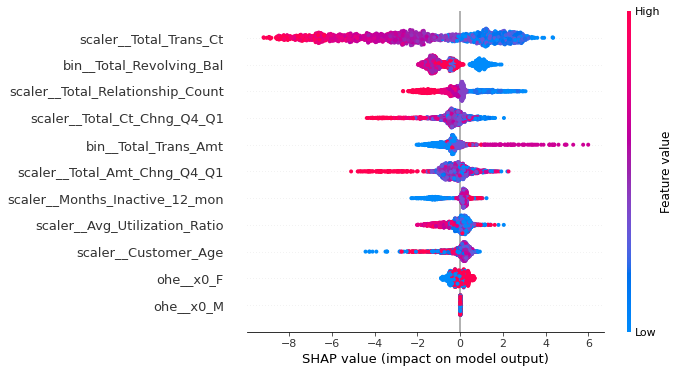

In [36]:
explainer = shap.TreeExplainer( clf_model )
shap_values = explainer.shap_values( X_test )
shap.summary_plot(shap_values, X_test, plot_type = 'dot' )

In [37]:
explainer.expected_value

-0.02304246

In [38]:
shap.initjs()
shap.force_plot( explainer.expected_value, 
                 shap_values, 
                 X_test )

## 4.3 Model Biasness

In [41]:
female_ref = reference[reference['ohe__x0_F']==1]
female_prod = production[production['ohe__x0_F']==1]

In [43]:
female_bias_report = Dashboard(tabs=[ClassificationPerformanceTab])
female_bias_report.calculate(female_ref, female_prod, column_mapping = None)
female_bias_report.save('../Reports/Model Biasness (Female).html')

In [44]:
male_ref = reference[reference['ohe__x0_F']==0]
male_prod = production[production['ohe__x0_F']==0]

In [46]:
male_bias_report = Dashboard(tabs=[ClassificationPerformanceTab])
male_bias_report.calculate(male_ref, male_prod, column_mapping = None)
male_bias_report.save('../Reports/Model Biasness (Male).html')

## 4.4 Model Card

In [47]:
from datetime import date
from io import BytesIO
from IPython import display
import model_card_toolkit as mctlib
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay

import base64
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import uuid

In [48]:
churn_train = pd.read_pickle('../DataFiles/Churn_train.pkl')
churn_test = pd.read_pickle('../DataFiles/Churn_test.pkl')

In [49]:
X_train = churn_train.drop('Attrition_Flag',axis = 1)
y_train = churn_train['Attrition_Flag']

X_test = churn_test.drop('Attrition_Flag',axis = 1)
y_test = churn_test['Attrition_Flag']

### Plots to include  in Model Card

In [50]:
# Utility function that will export a plot to a base-64 encoded string that the model card will accept.

def plot_to_str():
    img = BytesIO()
    plt.savefig(img, format='png')
    return base64.encodebytes(img.getvalue()).decode('utf-8')

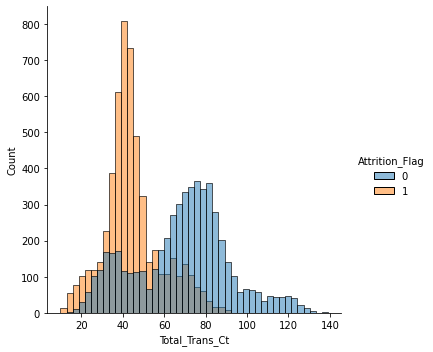

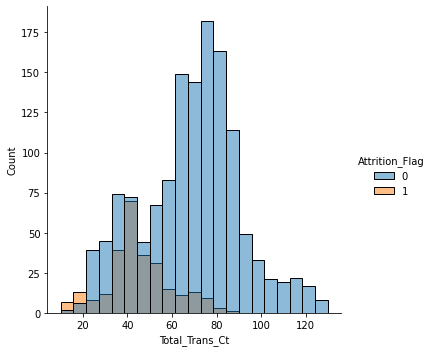

In [51]:
sns.displot(x = X_train['Total_Trans_Ct'], hue = y_train)
trans_cnt_train = plot_to_str()

sns.displot(x = X_test['Total_Trans_Ct'], hue = y_test)
trans_cnt_test = plot_to_str()

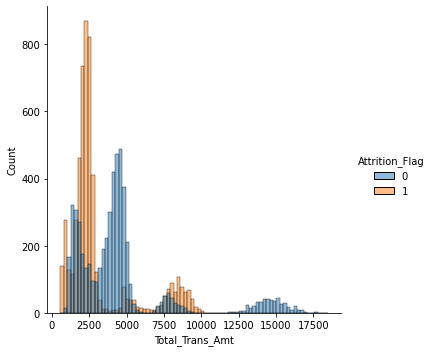

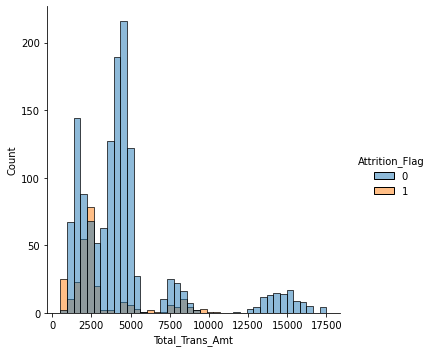

In [52]:
sns.displot(x = X_train['Total_Trans_Amt'], hue = y_train)
tran_amt_train = plot_to_str()

sns.displot(x = X_test['Total_Trans_Amt'], hue = y_test)
tran_amt_test = plot_to_str()

### Evaluation Metrics

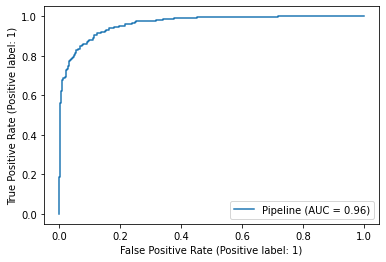

In [53]:
RocCurveDisplay.from_estimator(prediction_model.model,X_test,y_test)
roc_curve = plot_to_str()

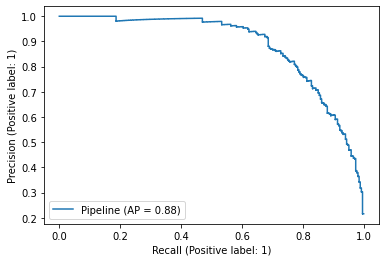

In [54]:
PrecisionRecallDisplay.from_estimator(prediction_model.model,X_test,y_test)
pr_curve = plot_to_str()

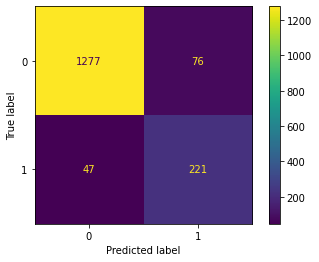

In [55]:
ConfusionMatrixDisplay.from_estimator(prediction_model.model, X_test,y_test)
cnf_matrix = plot_to_str()

### Initalise Model Card

In [56]:
mct = mctlib.ModelCardToolkit()
model_card = mct.scaffold_assets()

### Model Details

In [57]:
model_card.model_details.name = 'Credit Card Churners Dataset'
model_card.model_details.overview = (
    'This model predicts whether a credit card customers is Exsiting or has Attrited based on trnsaction and other details')
model_card.model_details.owners = [
    mctlib.Owner(name= 'Group 3 MLOps', contact='robin.raj@iimb.ac.in')
]
model_card.model_details.version.name = str("Version 1.0")
model_card.model_details.version.date = str(date.today())

### Users, Ethics, and Limitation

In [58]:
model_card.considerations.ethical_considerations = [mctlib.Risk(
    name=('Leakage of Private Financial Data'),
    mitigation_strategy='Anonymize data'
)]
model_card.considerations.limitations = [mctlib.Limitation(description='Limited by avaiablity of personal data')]
model_card.considerations.use_cases = [mctlib.UseCase(description='Predict Credit Card Customer Churn')]
model_card.considerations.users = [mctlib.User(description='Banking Institutions'), mctlib.User(description='ML researchers')]

### Training and Test Dataset Distributions

In [59]:
model_card.model_parameters.data.append(mctlib.Dataset(name="Training Dataset"))
model_card.model_parameters.data[0].graphics.description = (
  f'{len(X_train)} rows with {len(X_train.columns)} features')
model_card.model_parameters.data[0].graphics.collection = [
    mctlib.Graphic(image=trans_cnt_train),
    mctlib.Graphic(image=tran_amt_train)
]

model_card.model_parameters.data.append(mctlib.Dataset(name="Test Dataset"))
model_card.model_parameters.data[1].graphics.description = (
  f'{len(X_test)} rows with {len(X_test.columns)} features')
model_card.model_parameters.data[1].graphics.collection = [
    mctlib.Graphic(image=trans_cnt_test),
    mctlib.Graphic(image=tran_amt_test)
]


### Model Evaluation Details

In [60]:
model_card.quantitative_analysis.graphics.description = (
  'ROC,PR Curve and Confusion Matrix')
model_card.quantitative_analysis.graphics.collection = [
    mctlib.Graphic(image=roc_curve),
    mctlib.Graphic(image=pr_curve),
    mctlib.Graphic(image=cnf_matrix)
]

In [61]:
mct.update_model_card(model_card)

### Generate Model Card

In [62]:
html = mct.export_format(output_file='../Reports/ModelCard.html')

### Preview

In [63]:
display.display(display.HTML(html))